## Рекомендательная система курсов дополнительного образования НИУ ВШЭ

### Ознакомление с данными и препроцессинг

#### Подгрузка библиотек и датасетов

In [1]:
import pandas as pd
import re
import requests
from tqdm.auto import tqdm
import numpy as np
import collections
import lightfm
import pandas_profiling

df = pd.read_csv('./data_t_row_6m.csv')
tqdm.pandas(desc='Proccessing_rows')

HOME_PAGE = 'https://www.hse.ru/edu/dpo/'


#### Изучаем строение датасета

In [2]:
# pandas_profiling.ProfileReport(df, title="Raw Data Profiling Report").to_file("RawDataProfile.html")

In [3]:
df['event_name'].unique()

array(['start_session', 'dom_content_loaded', 'pageview',
       'tracker_created', 'window_loaded', 'fingerprint',
       'window_unloaded', 'link_click', 'something_clicked',
       'button_click', 'radio_change', 'radio_click', 'text_click',
       'text_change', 'checkbox_click', 'checkbox_change', 'submit_form',
       'tel_click', 'tel_change', 'textarea_click', 'textarea_change',
       'email_click', 'email_change', 'file_click', 'file_change',
       'search_click', 'search_change', 'form_submit'], dtype=object)

In [4]:
def vaildation(link):
    if requests.get(link).status_code != 200:
        return None
    return link

def get_links_that_start_not_with_home_page(x):
    if x.find(HOME_PAGE) == 0:
        return None
    return x

target_links = df['current_location'].apply(get_links_that_start_not_with_home_page).unique()
valid_links = list()
for i in target_links:
    if i is not None:
        answer = vaildation(i)
        if answer is not None:
            valid_links.append(answer)

valid_links

['https://webcache.googleusercontent.com/search?q=cache:-Mcy3IiylbMJ:https://www.hse.ru/edu/dpo/578560476&cd=24&hl=ru&ct=clnk&gl=ru',
 'https://webcache.googleusercontent.com/search?q=cache:uRmsm8US0PYJ:https://www.hse.ru/edu/dpo/473021647&cd=1&hl=ru&ct=clnk&gl=ru',
 'https://webcache.googleusercontent.com/search?q=cache:lLlsWnjAR8MJ:https://www.hse.ru/edu/dpo/494685723&cd=12&hl=ru&ct=clnk&gl=kz']

3 ссылки это выбос. Я считаю ими можно пренебречь, чтобы получить приятный инвариант вида: все ссылки начинаются с HOME_PAGE

#### Очистка ссылок от лишних key-value параметров

In [5]:
df['clear_location'] = df['current_location'].progress_apply(lambda x: x.split('?')[0]).progress_apply(lambda x: x.split(':~:text')[0]).progress_apply(lambda x: re.sub('/#', '#', x)).progress_apply(lambda x: re.sub('[#/]$', '', x))
print("clear_location:", len(df['clear_location'].unique()), "\ncurrent_location:", len(df['current_location'].unique()), sep=" ")

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

clear_location: 2255 
current_location: 63026


#### Отсоединение якорей от ссылок:

In [6]:
def get_anchor(link):
    if link is None:
        return None
    arr = link.split(sep='#')
    arr.append(None)
    return arr[1]

def del_anchor(link):
    if link is None:
        return None
    arr = link.split(sep='#')
    return arr[0]

print ("clear_location_with_anchors:", len(df['clear_location'].unique()), sep = " ")
df['anchor'] = df['clear_location'].progress_apply(lambda x: re.sub('%23', '#', x)).progress_apply(get_anchor)
df['clear_location'] = df['clear_location'].progress_apply(del_anchor)
print ("clear_location_without_anchors:", len(df['clear_location'].unique()), sep = " ")

clear_location_with_anchors: 2255


Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

Proccessing_rows:   0%|          | 0/3684257 [00:00<?, ?it/s]

clear_location_without_anchors: 816


In [1]:
df['clear_location'].unique().tolist()

In [8]:
len(df['anchor'].unique())

129

In [9]:
df['anchor'].unique().tolist()

[None,
 'contacts',
 'price',
 'teachers',
 'programm',
 'foreword',
 'schedule',
 'programme',
 'program',
 'process',
 'about',
 'staff',
 'who',
 'speakers',
 'graduates',
 'valueproposition',
 'doc',
 'documents',
 'feedback',
 'reviews',
 'skills',
 'document',
 'student',
 'us',
 'get',
 'you',
 'results',
 'forwhom',
 'prog',
 'prog1',
 'prog3',
 'tex8',
 'audience',
 'comments',
 'advantages',
 'graduate',
 'priceandterms',
 'prepodavateli',
 'for',
 'terms',
 'studyformat',
 'important',
 'programma',
 'students',
 'auditory',
 'contact',
 'format',
 'obuchenie',
 'certificate',
 'we',
 'technology',
 'timetable',
 'tex5',
 'tutors',
 'teacher',
 'online',
 'programe',
 'dokument',
 'test',
 'review',
 'cousresandauthors',
 'teach',
 'block',
 'cost',
 'zayvka',
 'contakt',
 'tex3',
 'tex4',
 'tex7',
 'exam',
 'oid1',
 'anchor',
 'prof',
 'oid3',
 'abitur',
 'education',
 'contactus',
 'tex1',
 'tex6',
 'tex9',
 'contents',
 'prepod',
 'passport',
 'teaching',
 'oid2',
 'faq',

#### Удаляем невалидные ссылки (404)

Отфильтруем ссылки на валидность:

In [10]:
clear_location = df['clear_location'].unique()
clear_valid_location = dict()

In [11]:
keys = clear_valid_location.keys()

for link in tqdm(clear_location):
    if link not in keys:
        clear_valid_location[link] = vaildation(link)

  0%|          | 0/816 [00:00<?, ?it/s]

In [12]:
df['clear_valid_location'] = df['clear_location'].apply(lambda x: clear_valid_location[x])

Кол-во валидных чистых ссылок:

In [13]:
len(df['clear_valid_location'].unique())

571

In [2]:
df['clear_valid_location'].unique().tolist()

### Исследование

#### Garbage

In [15]:
df.groupby('clear_valid_location').agg({'event_name':lambda x: (x == 'start_session').sum()}).query('event_name == 0').count()

event_name    59
dtype: int64

In [16]:
df['clear_valid_location'].value_counts()

https://www.hse.ru/edu/dpo/482696965    80019
https://www.hse.ru/edu/dpo/480913829    77686
https://www.hse.ru/edu/dpo/486313491    65648
https://www.hse.ru/edu/dpo/471334078    58628
https://www.hse.ru/edu/dpo/463201113    47321
                                        ...  
https://www.hse.ru/edu/dpo/662143923        6
https://www.hse.ru/edu/dpo/465488437        6
https://www.hse.ru/edu/dpo/465492063        5
https://www.hse.ru/edu/dpo/465140634        5
https://www.hse.ru/edu/dpo/589486554        4
Name: clear_valid_location, Length: 570, dtype: int64

In [17]:
def GetCourseIdFromLink(link: str):
    if link == None:
        return None
    if link.find(HOME_PAGE) != 0:
        return None
    start = len(HOME_PAGE)
    end = start
    while end != len(link) and link[end].isnumeric():
        end += 1
    return link[start:end]
    
df['clear_valid_location'].apply(GetCourseIdFromLink).value_counts()

482696965    80019
480913829    77686
486313491    65648
471334078    58628
463201113    47321
             ...  
662143923        6
465488437        6
465492063        5
465140634        5
589486554        4
Name: clear_valid_location, Length: 570, dtype: int64

<AxesSubplot:>

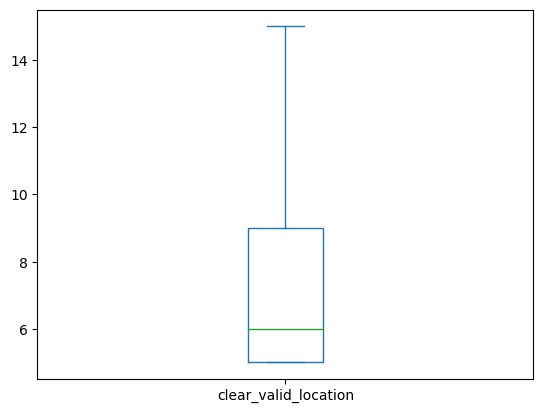

In [18]:
df['second_id'] = df.user_id.map(lambda x: x.split('|')[1])
df.groupby('second_id').clear_valid_location.nunique().to_frame().query("clear_valid_location >=5").sort_values('clear_valid_location').plot.box(showfliers=False)

#### Исследование данных для расстановки весов

In [19]:
df[df['event_name'] == 'submit_form']['anchor'].value_counts()

price               90
programme           62
about               54
contacts            43
program             33
schedule            16
teachers            14
speakers             9
technology           8
you                  6
graduates            5
documents            5
process              4
comments             4
tutors               4
format               3
faq                  2
valueproposition     2
interiors            2
feedback             1
prepod               1
priceandterms        1
us                   1
forwhom              1
tex8                 1
who                  1
teacher              1
programm             1
skills               1
review               1
reviews              1
students             1
results              1
terms                1
staff                1
document             1
Name: anchor, dtype: int64

In [21]:
df.shape

(3684257, 8)

In [22]:
user_sessions = collections.defaultdict(list)

for _, row in df.sort_values(by=['event_timestamp']).iterrows():
    if row['second_id'] == None or row['second_id'] == 'none':
        continue
    if len(user_sessions[row['second_id']]) == 0 or row['event_name'] == 'start_session':
        user_sessions[row['second_id']].append(list())
    user_sessions[row['second_id']][-1].append(row['event_name'])

In [3]:
for l in user_sessions.values():
    for session in l:
        if len(session) > 1:
            print(session)


### Построение матрицы взаимодейтсвий

In [23]:
df = df.dropna(subset=['clear_valid_location', 'second_id'])
df = df[df['second_id'] != 'none']

In [28]:
df = df.dropna(subset=['clear_valid_location', 'second_id'])
df = df[df['second_id'] != 'none']

courses = df["clear_valid_location"].unique()
users = df["second_id"].unique()
banned_users = list()

for user, sessions in user_sessions.items():
    is_banned = True
    for session in sessions:
        if len(session) >= 1:
            is_banned = False
            break
    if is_banned:
        banned_users.append(user)

users = list(set(users.tolist()).symmetric_difference(set(banned_users)))

Отсутствие взаимодействия --- 0 \
Посетил страницу --- 0.1 \
Наличие якорей --- от 0.13 до 0.4, функция логарифм от кол-ва якорей с достаточно большим основанием \
Что-то нажато + нажатие кнопок разных типов --- добавляет к сумме сколько-то за каждое нажатие

Отправка вопроса --- 0.6 \
Отправка формы --- 1

In [29]:
df_grouped_by_id = df.groupby(['second_id', 'clear_valid_location'])
interactions = pd.DataFrame(0, columns=courses, index=users)

In [ ]:
browser_events = ['start_session', 'fingerprint', 'tracker_created', 'dom_content_loaded']

def get_coef(user, course):
    coef = 0

    cur_inter = df_grouped_by_id.get_group((user, course))

    # Если пользователь хоть раз посетил сразу добавляем 0.1
    if cur_inter.shape[0] != 0:
        coef += 0.08
    
    cur_inter = cur_inter.query('event_name not in @browser_events')
    # + за каждый эвент на странице
    coef += min(0.2, np.log(cur_inter.shape[0] + 1) * 0.4 / np.log(100000))

    anchors = cur_inter['anchor'].unique()
    # + за каждую ссылку с якорем
    coef += min(0.4, np.log(len(anchors) + 1) / np.log(1000))

    events = cur_inter['event_name'].unique()
    # +1 за форму, т.к. самый сильный тип взаимодействия
    if 'submit_form' in events or 'form_submit' in events:
        coef += 1
    
    return coef

for user, course in df_grouped_by_id.groups.keys():
    interactions.loc[user, course] = get_coef(user, course)

In [ ]:
interactions = interactions.loc[(interactions!=0).any(axis=1)]
interactions

,https://www.hse.ru/edu/dpo/463158543,https://www.hse.ru/edu/dpo/480913728,https://www.hse.ru/edu/dpo/486319561,https://www.hse.ru/edu/dpo/471334078,https://www.hse.ru/edu/dpo/480508962,https://www.hse.ru/edu/dpo/595545243,https://www.hse.ru/edu/dpo/480913829,https://www.hse.ru/edu/dpo/465317778,https://www.hse.ru/edu/dpo/446316061,https://www.hse.ru/edu/dpo/472498353,...,https://www.hse.ru/edu/dpo/789900533,https://www.hse.ru/edu/dpo/465487598,https://www.hse.ru/edu/dpo/773679259,https://www.hse.ru/edu/dpo/465488207,https://www.hse.ru/edu/dpo/793917085,https://www.hse.ru/edu/dpo/589486554,https://www.hse.ru/edu/dpo/796311892,https://www.hse.ru/edu/dpo/795955343,https://www.hse.ru/edu/dpo/795955345,https://www.hse.ru/edu/dpo/797392978
166826354536403284,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1659090028176813185,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1662653630805002670,0.0,0.0,0.218513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1667388264394057150,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1666014310920836055,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662407034258674228,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665826640406257416,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166680056086770561,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668189827160039838,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
interactions.apply(lambda x: x != 0).sum().sum() / (interactions.shape[0] * interactions.shape[1])

0.0027214479965267592

In [ ]:
interactions.to_csv('interactions_matrix.csv')